In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Paths

In [4]:
project_dir = "../"
metadata_dir = f"{project_dir}/metadata/"
data_dir = "/home/nikhil/projects/brain_changes/data/"

train_csv = f"{metadata_dir}/ukbb/ukbb_train_data.csv"
test_csv = f"{metadata_dir}/ukbb/ukbb_test_data.csv"

summary_results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/summary/ohbm2022/"

# ukbb
tab_follow_up_csv = f"{data_dir}ukbb/tabular/ukbb_follow_up_demographics.csv"
brain_age_ses2_p1_csv = f"{data_dir}ukbb/results/brain-age_ukbb-followup_ses-2_p1_SFCN-run-1_results.csv"
brain_age_ses2_p2_csv = f"{data_dir}ukbb/results/brain-age_ukbb-followup_ses-2_p2_SFCN-run-1_results.csv"
brain_age_ses3_csv = f"{data_dir}ukbb/results/brain-age_ukbb-followup_ses-3_SFCN-run-1_results.csv"

# adni
adni_demograph_csv = f"{data_dir}adni/metadata/ADNIMERGE.csv"

mni_space = "MNI152NLin6Sym" # "MNI152NLin6Sym" or "MNI152Lin"

cohort = "ukbb" #"adni"

if mni_space == "MNI152NLin6Sym":
    adni_brain_age_bl_csv = f"{data_dir}adni/results/adni_sfcn_MNI152NLin6Sym_ohbm_bl_masked_results.csv"
    adni_brain_age_m24_csv = f"{data_dir}adni/results/adni_sfcn_MNI152NLin6Sym_ohbm_m24_masked_results.csv"

else:
    adni_brain_age_bl_csv = f"{data_dir}adni/results/adni_sfcn_ohbm_bl_masked_results.csv"
    adni_brain_age_m24_csv = f"{data_dir}adni/results/adni_sfcn_ohbm_m24_masked_results.csv"


## Read results

### UKBB or ADNI

In [5]:
if cohort == "ukbb":

    ukbb_tab_followup_df = pd.read_csv(tab_follow_up_csv)
    ukbb_tab_followup_df = ukbb_tab_followup_df.reset_index()
    brain_age_ses2_p1_df = pd.read_csv(brain_age_ses2_p1_csv)
    brain_age_ses2_p2_df = pd.read_csv(brain_age_ses2_p2_csv)

    brain_age_ses2_df = brain_age_ses2_p1_df.append(brain_age_ses2_p2_df)
    brain_age_ses2_df = brain_age_ses2_df.rename(columns={"pred":"pred_at_ses2", "prob":"prob_at_ses2"})
    brain_age_ses2_df = brain_age_ses2_df.drop(columns=["Unnamed: 0"])

    brain_age_ses3_df = pd.read_csv(brain_age_ses3_csv)
    brain_age_ses3_df = brain_age_ses3_df.rename(columns={"pred":"pred_at_ses3", "prob":"prob_at_ses3"})
    brain_age_ses3_df = brain_age_ses3_df.drop(columns=["Unnamed: 0"])

    brain_age_ses2_success = list(brain_age_ses2_df.index)
    brain_age_ses3_success = list(brain_age_ses3_df.index)

    print(f"Number of successful predictions\n ses-2: {len(brain_age_ses2_success)}, ses-3: {len(brain_age_ses3_success)}")

    brain_age_df = pd.merge(brain_age_ses2_df, brain_age_ses3_df, on="eid", how="inner")
    brain_age_df = pd.merge(brain_age_df, ukbb_tab_followup_df, on="eid", how="left")
    brain_age_df["scan_interval"] = brain_age_df["age_at_ses3"] - brain_age_df["age_at_ses2"]

    print(f"Number of brain-age subjects: {len(brain_age_df)}")

    ### this is techinically not a train subset for SFCN but excluding these to be consistent with other models trained on long-subset
    train_df = pd.read_csv(train_csv) 
    test_df = pd.read_csv(test_csv) 

    train_eids = train_df["eid"].values
    test_eids = test_df["eid"].values

    brain_age_df.loc[brain_age_df["eid"].isin(train_eids),"subset"] = "valid"
    brain_age_df.loc[brain_age_df["eid"].isin(test_eids),"subset"] = "test"

elif cohort == "adni":
    adnimerge_df = pd.read_csv(adni_demograph_csv)
    print(f"ADNIMERGE len: {len(adnimerge_df)}")

    adnimerge_df["eid"] = "sub-ADNI" + adnimerge_df["PTID"]
    adnimerge_df["eid"] = adnimerge_df["eid"].str.replace("_","")

    useful_cols = ["eid","DX_bl","AGE","PTGENDER","VISCODE"]
    adnimerge_dx_df = adnimerge_df[(adnimerge_df["VISCODE"]=="bl")][useful_cols]

    adnimerge_dx_df["age_at_ses2"] = adnimerge_dx_df["AGE"]
    adnimerge_dx_df["age_at_ses3"] = adnimerge_dx_df["AGE"] + 2

    print(f"adnimerge with longitudinal subjects. n_subjects = {len(adnimerge_dx_df)}")

    brain_age_ses2_df = pd.read_csv(adni_brain_age_bl_csv)
    brain_age_ses2_df = brain_age_ses2_df.rename(columns={"pred":"pred_at_ses2", "prob":"prob_at_ses2"})
    brain_age_ses2_df = brain_age_ses2_df.drop(columns=["Unnamed: 0"])
    brain_age_ses2_df["eid"] = "sub-" + brain_age_ses2_df["eid"]
    brain_age_ses2_success = list(brain_age_ses2_df.index)

    brain_age_ses3_df = pd.read_csv(adni_brain_age_m24_csv)
    brain_age_ses3_df = brain_age_ses3_df.rename(columns={"pred":"pred_at_ses3", "prob":"prob_at_ses3"})
    brain_age_ses3_df = brain_age_ses3_df.drop(columns=["Unnamed: 0"])
    brain_age_ses3_df["eid"] = "sub-" + brain_age_ses3_df["eid"]
    brain_age_ses3_success = list(brain_age_ses3_df.index)

    print(f"Number of successful predictions\n ses-2: {len(brain_age_ses2_success)}, ses-3: {len(brain_age_ses3_success)}")

    brain_age_df = pd.merge(brain_age_ses2_df, brain_age_ses3_df, on="eid", how="inner")
    brain_age_df = pd.merge(brain_age_df, adnimerge_dx_df, on="eid", how="inner")
    brain_age_df["scan_interval"] = brain_age_df["age_at_ses3"] - brain_age_df["age_at_ses2"]

    brain_age_df["subset"]= "test"

    print(f"Number of brain-age subjects: {len(brain_age_df)}")

else:
    print(f"unknown cohort: {cohort}")

brain_age_df.head()

Number of successful predictions
 ses-2: 3044, ses-3: 3065
Number of brain-age subjects: 2933


,eid,pred_at_ses2,prob_at_ses2,pred_at_ses3,prob_at_ses3,index,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment,scan_interval,subset
0,1004084,66.834612,[0.00090773 0.00093408 0.00098936 0.00085202 0...,68.104931,[0.00107993 0.00113779 0.00132602 0.00138609 0...,1,1.0,1947.0,2017-05-23,2019-10-23,20252_2_0,20252_3_0,1001.0,70.0,72.0,60.0,2.0,valid
1,1010063,52.458433,[2.85410097e-05 4.52067616e-05 2.40045178e-04 ...,53.228092,[2.9535762e-05 4.5728742e-05 2.2089168e-04 2.0...,3,0.0,1964.0,2017-07-05,2019-10-29,20252_2_0,20252_3_0,1001.0,53.0,55.0,45.0,2.0,valid
2,1014782,61.505157,[2.0425497e-04 2.2044049e-04 2.6866587e-04 2.3...,66.927790,[0.00119282 0.00128485 0.0016164 0.00184236 0...,9,1.0,1947.0,2017-09-21,2019-10-24,20252_2_0,20252_3_0,1001.0,70.0,72.0,61.0,2.0,valid
3,1016215,65.544100,[2.03753036e-04 2.05709584e-04 1.98428897e-04 ...,68.055118,[2.04080905e-04 2.08782920e-04 2.15765467e-04 ...,10,1.0,1951.0,2017-07-07,2019-09-01,20252_2_0,20252_3_0,1001.0,65.0,67.0,56.0,2.0,test
4,1022531,65.136880,[0.00093911 0.00100203 0.00120763 0.001233 0...,68.032131,[0.00086184 0.00089053 0.00096467 0.00089484 0...,15,1.0,1951.0,2017-06-09,2019-10-01,20252_2_0,20252_3_0,1001.0,66.0,68.0,58.0,2.0,test


## Bias correction
- fit: brainage = a * chronoage + b on adni-CN 
- correct_brainage = (brainage - b) / a
- Note: we don't want to calculate separate a,b for ses-2 and ses-3

In [6]:
from sklearn.linear_model import LinearRegression
bias_corr_sampx = 100

for ses in ["ses2","ses3"]:
    if cohort == "adni":
        NC_brainage = brain_age_df[brain_age_df["DX_bl"]=="CN"][f"pred_at_ses2"].values.reshape(-1, 1)
        NC_chronoage = brain_age_df[brain_age_df["DX_bl"]=="CN"][f"age_at_ses2"].values.reshape(-1, 1)

    else:
        NC_brainage = brain_age_df[brain_age_df["subset"]=="valid"][f"pred_at_ses2"].values[:bias_corr_sampx].reshape(-1, 1)
        NC_chronoage = brain_age_df[brain_age_df["subset"]=="valid"][f"age_at_ses2"].values[:bias_corr_sampx].reshape(-1, 1)

    reg = LinearRegression().fit(NC_chronoage, NC_brainage)

    a = np.squeeze(reg.coef_)
    b = np.squeeze(reg.intercept_)

    print(f"cohort: {cohort}, ses:{ses}, a={a:3.2f}, b={b:3.2f}")

    brain_age_df[f"pred_at_{ses}_bias_corr"] = (brain_age_df[f"pred_at_{ses}"].values - b) / a


cohort: ukbb, ses:ses2, a=0.76, b=11.25
cohort: ukbb, ses:ses3, a=0.76, b=11.25


## Calculate MAEs
- ses2, ses3, and delta

In [7]:
brain_age_df = brain_age_df[brain_age_df["subset"]=="test"]
perf_df = brain_age_df[["eid","age_at_ses2","age_at_ses3","pred_at_ses2_bias_corr","pred_at_ses3_bias_corr"]]
perf_df = perf_df.rename(columns={"pred_at_ses2_bias_corr":"brainage_at_ses2","pred_at_ses3_bias_corr":"brainage_at_ses3"})

perf_df["model"] = "SFCN"

perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]
perf_df["baseline_abs_err"] = np.abs(perf_df["baseline_err"])
perf_df["followup_abs_err"] = np.abs(perf_df["followup_err"])

perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]

perf_df["chronoage_delta"] = np.round(perf_df["chronoage_delta"],3) ### For some odd reasons without rounding, this creates a few subjects with chronoage_delta !=2 

perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]
perf_df["delta_abs_err"] = np.abs(perf_df["delta_err"])

perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

n_BBs = perf_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(perf_df):4.3f}%)")

perf_df_melt = perf_df.melt(id_vars=["eid", "model", "age_at_ses2",	"brainage_at_ses2",	"age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

n BBs: 92 (34.457%)


chronoage_delta  model  err_type    
2.0              SFCN   baseline_err    5.588229
                        delta_err       4.562912
                        followup_err    5.688599
Name: abs_error, dtype: float64


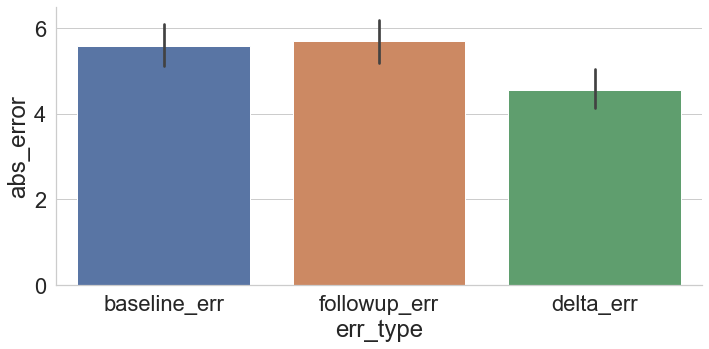

In [8]:
plot_df = perf_df_melt.copy()
plot_df["abs_error"] = np.abs(plot_df["error"]) 
print(plot_df.groupby(["chronoage_delta","model","err_type"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", kind="bar", data=plot_df,aspect=2)

In [12]:
save_summary_results = False
if save_summary_results:
    if cohort == "ukbb":
        perf_df.to_csv(f"{summary_results_dir}single_visit_SFCN_ukbb_bias_corr_perf.csv")
    else:
        perf_df.to_csv(f"{summary_results_dir}single_visit_SFCN_{mni_space}_adni_bias_corr_perf.csv")

    print(cohort, mni_space)

adni MNI152NLin6Sym


## Legacy performance plots

MAE = 5.59 (std = 4.18)
 Pearsons r= (0.6951988511317125, 7.07965046973609e-40)
MAE = 5.69 (std = 4.36)
 Pearsons r= (0.6134062332793784, 5.455250880047417e-29)


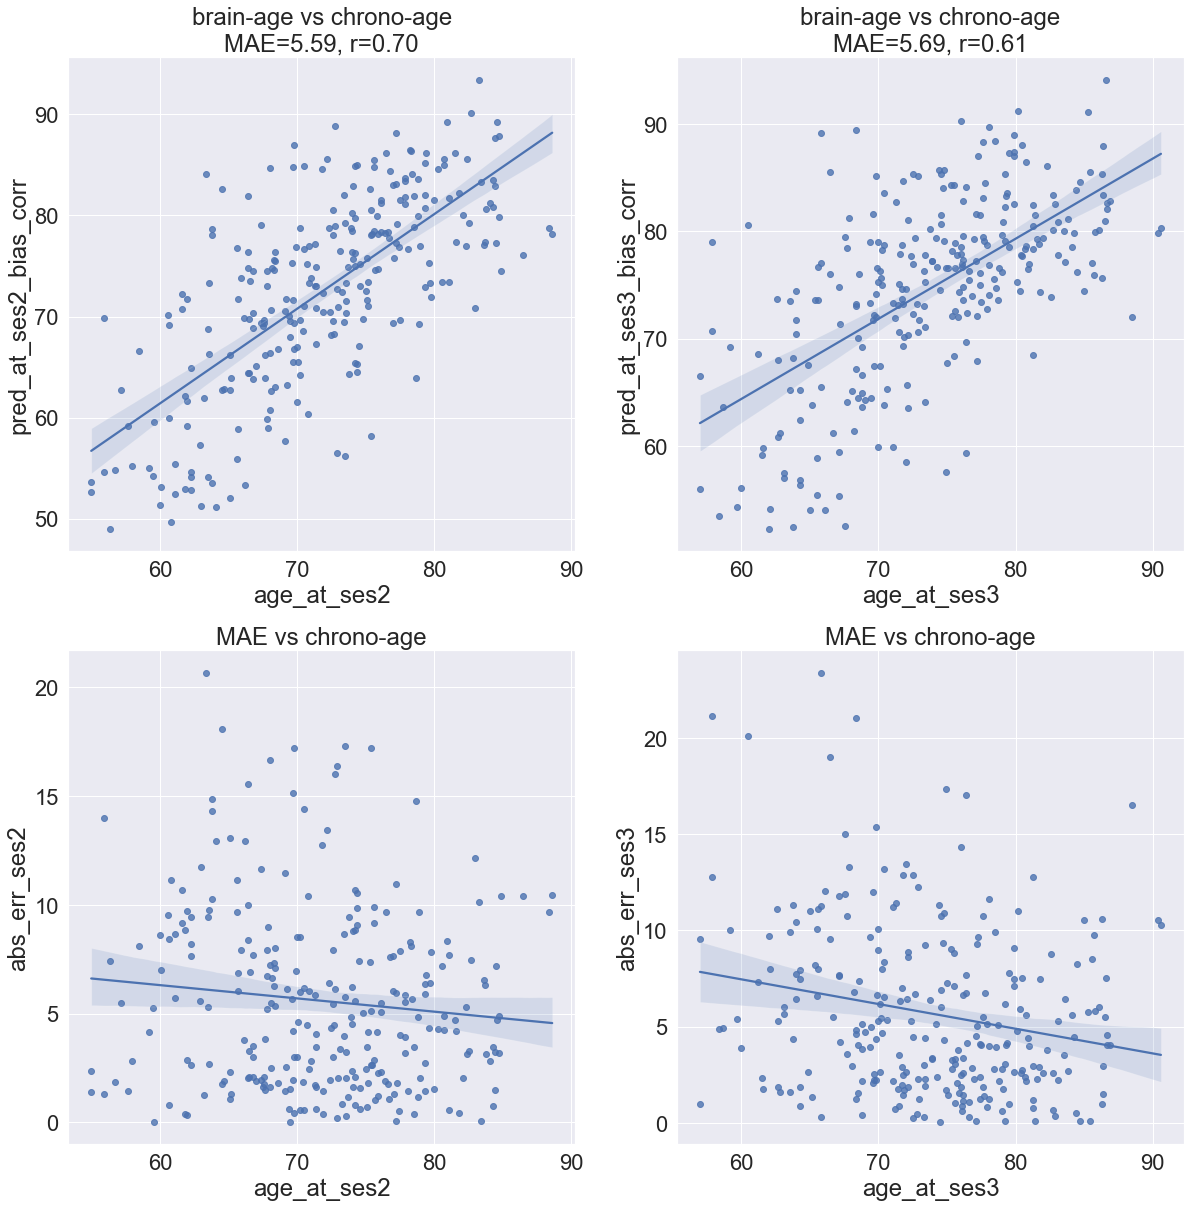

In [10]:
## MAE
palette = 'husl'
sns.set(font_scale=2)

fig, axes = plt.subplots(2,2,figsize=(20,20))
sessions = ["ses2", "ses3"]

plot_df = brain_age_df.copy()
for s, session in enumerate(sessions): 
    y_true = plot_df[f"age_at_{session}"]
    y_pred = plot_df[f"pred_at_{session}_bias_corr"]

    abs_err = np.abs(y_pred - y_true)
    plot_df[f"abs_err_{session}"] = abs_err

    MAE = np.mean(abs_err)
    std_AE = np.std(abs_err)

    corr = stats.pearsonr(y_true, y_pred)
    print(f"MAE = {MAE:3.2f} (std = {std_AE:3.2f})\n Pearsons r= {corr}")

    # Plots
    with sns.axes_style("whitegrid"):    
        ax = axes[0,s]
        g = sns.regplot(x=f"age_at_{session}", y=f"pred_at_{session}_bias_corr", data=plot_df, ax=ax)
        g.set_title(f"brain-age vs chrono-age\nMAE={MAE:3.2f}, r={corr[0]:3.2f}")

        ax = axes[1,s]
        g = sns.regplot(x=f"age_at_{session}", y=f"abs_err_{session}", data=plot_df, ax=ax)
        g.set_title("MAE vs chrono-age")



## Correlation between ses2 and ses3 errors

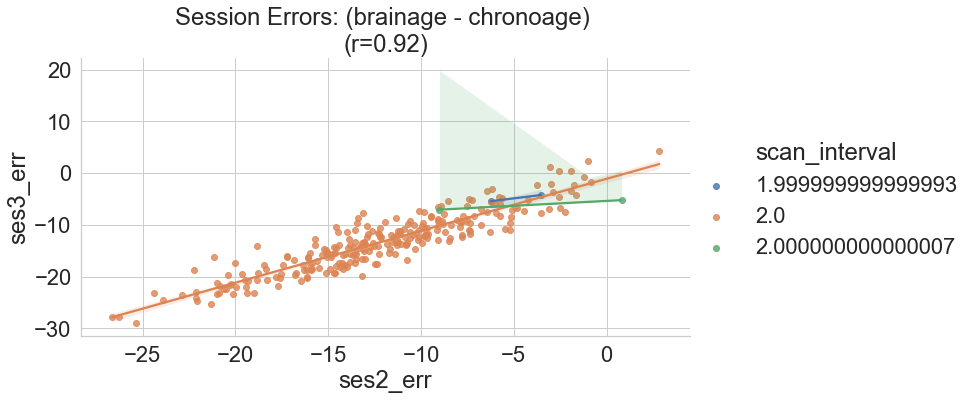

In [11]:
plot_df = brain_age_df.copy()
plot_df["ses2_err"] = plot_df["pred_at_ses2"] -  plot_df["age_at_ses2"]
plot_df["ses3_err"] = plot_df["pred_at_ses3"] -  plot_df["age_at_ses3"]
corr = stats.pearsonr(plot_df["ses2_err"],plot_df["ses3_err"])

with sns.axes_style("whitegrid"):    
    g = sns.lmplot(x="ses2_err", y="ses3_err", hue="scan_interval", data=plot_df, aspect=2)
    plt.title(f"Session Errors: (brainage - chronoage) \n(r={corr[0]:3.2f})")

## Plot ses2 vs ses3 age

In [ ]:
followup_diff = brain_age_df["pred_at_ses3"] - brain_age_df["pred_at_ses2"]
brain_age_df["Brain-age (ses3 - ses2)"] = followup_diff

neg_age_count = np.sum(followup_diff < 0)

print(f"number of Benjamine Buttons: {neg_age_count} ({100*neg_age_count/len(brain_age_df):3.2f}%)")

print(brain_age_df.groupby(["scan_interval","sex"]).mean().reset_index()[["sex","scan_interval","Brain-age (ses3 - ses2)"]])

plot_df = brain_age_df.copy()
m,s = np.mean(plot_df["Brain-age (ses3 - ses2)"]), np.std(plot_df["Brain-age (ses3 - ses2)"])
print(f"Brain-age prediction (ses3 - ses2), mean: {m:3.2f} ({s:3.2f})")

# Plots
with sns.axes_style("whitegrid"): 
    fig,ax=plt.subplots(figsize=(20,7))
    palette = 'husl'
    g = sns.histplot(x="Brain-age (ses3 - ses2)", hue="scan_interval", data=brain_age_df, palette=palette)
    g.set_title(f"Brain-age: (ses3 - ses2)")
    plt.axvline(0, color="black",ls="--",lw=2)

## BBs and associate traits

In [ ]:
plot_df = brain_age_df.copy()

palette = 'husl'
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
        g = sns.lmplot(y="age_at_ses2", x="Brain-age (ses3 - ses2)", hue="scan_interval", data=plot_df, aspect=2)
        plt.axvline(0, color="black",ls="--",lw=2)
        plt.title(f"Brain-age delta vs chrono-age")

## Sex differences

In [ ]:
plot_df = brain_age_df.copy()
palette = 'husl'
sns.set(font_scale=1)

with sns.axes_style("whitegrid"):
    g = sns.lmplot(x="age_at_ses2", y=f"pred_at_{session}", hue="sex",data=plot_df)
    plt.title("brain-age vs chrono-age")

In [7]:
441-50

391

## GradBoost test (multiclass)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble

n_sampx = 1000
n_feat = 100
n_tasks = 1

X1 = np.random.rand(n_sampx,n_feat)
X2 = 2*np.random.rand(n_sampx,n_feat)
X1_mean = np.mean(X1)
X2_mean = np.mean(X2)
print(f"means, X1:{X1_mean}, X2:{X2_mean}")

y1 = np.zeros((n_sampx,n_tasks))
y2 = np.ones((n_sampx,n_tasks))

X = np.concatenate([X1,X2],axis=0)
y = np.squeeze(np.concatenate([y1,y2],axis=0))

print(f"shapes, X: {X.shape}, y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

y_pred = np.squeeze(clf.predict(X_test))

n_correct = np.sum(y_pred == y_test)
acc = n_correct/len(y_test)
print(f"Test acc: {acc}")

means, X1:0.4991987363994439, X2:1.0003052631981977
shapes, X: (2000, 100), y: (2000,)
Test acc: 0.999375


In [51]:
a = 4*["a"]

In [52]:
a


['a', 'a', 'a', 'a']